In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

In [3]:
iris = sns.load_dataset('iris')

data = torch.tensor(iris[iris.columns[0:4]].values).float()

labels = torch.zeros(len(data), dtype = torch.long)
labels[iris.species=='versicolor'] = 1
labels[iris.species=='virginica'] = 2

In [4]:
train_data, test_data, train_y, test_y = train_test_split(data, labels, test_size=.2)

train_dataset = TensorDataset(train_data, train_y)
test_dataset = TensorDataset(test_data, test_y)

batch_size=16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=test_dataset.tensors[0].shape[0], shuffle=True)

In [5]:
class ClassificationModel(nn.Module):
    def __init__(self, dropout_rate):
        super().__init__()
        
        self.input = nn.Linear(4, 12)
        self.hidden = nn.Linear(12, 12)
        self.output = nn.Linear(12, 3)
        
        self.dropout_rate = dropout_rate
        
    def forward(self, x):
        x = F.relu(self.input(x)) 
        
        x = F.dropout(x,p=self.dropout_rate, training=self.training)
        
        x = F.relu(self.hidden(x))
        
        x = F.dropout(x,p=self.dropout_rate, training=self.training)
        
        x = self.output(x)
        return x

In [10]:
def create_model(dropout_rate):
    model = ClassificationModel(dropout_rate)
    
    lossfun = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=.005)
    return model, lossfun, optimizer

In [11]:
num_of_epochs = 500

def train_model(model, loss_func, optimizer):
    train_acc = []
    test_acc = [] 
    
    for epoch in range(num_of_epochs):
        model.train()
        batch_acc = []
        for X, y in train_loader:
            yHat = model(X)
            loss = loss_func(yHat, y)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            batch_acc.append(100*torch.mean((torch.argmax(yHat, axis=1)==y).float()).item())
            
        train_acc.append(np.mean(batch_acc))
        
        model.eval()
        X,y = next(iter(test_loader))
        predlabels = torch.argmax(model(X), axis=1)
        test_acc.append(100*torch.mean((predlabels==y).float()).item())
    
    return train_acc, test_acc

In [12]:
dropout_rate = .0
model, lossfun, optimizer = create_model(dropout_rate)

train_acc, test_acc = train_model(model, lossfun, optimizer)

In [14]:
def smooth(x, k=5):
    return np.convolve(x, np.ones(k)/k, mode='same')

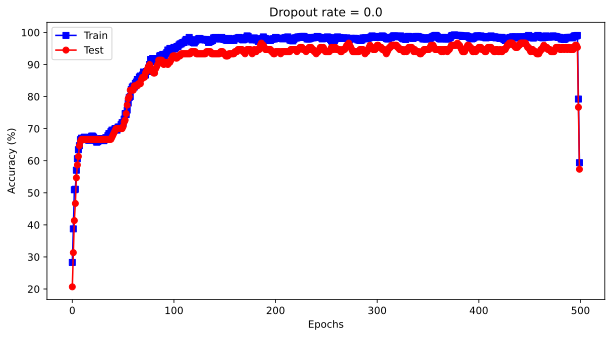

In [15]:
plt.figure(figsize=(10,5))

plt.plot(smooth(train_acc), 'bs-')
plt.plot(smooth(test_acc), 'ro-')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend(['Train', 'Test'])
plt.title(f"Dropout rate = {dropout_rate}")
plt.show()

In [16]:
dropout_rates = np.arange(10)/10
results = np.zeros((len(dropout_rates), 2))
for di in range(len(dropout_rates)):
    model, lossfun, optimizer = create_model(dropout_rates[di])

    train_acc, test_acc = train_model(model, lossfun, optimizer)

    results[di, 0] = np.mean(train_acc[-50:])
    results[di, 1] = np.mean(test_acc[-50:])

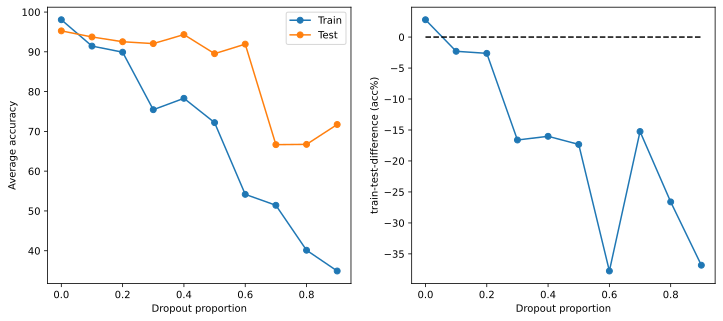

In [17]:
fig, ax = plt.subplots(1,2, figsize=(12,5))

ax[0].plot(dropout_rates, results, 'o-')
ax[0].set_xlabel('Dropout proportion')
ax[0].set_ylabel('Average accuracy')
ax[0].legend(['Train', 'Test'])

ax[1].plot(dropout_rates, -np.diff(results, axis=1), 'o-')
ax[1].plot([0, .9], [0, 0], 'k--')
ax[1].set_xlabel('Dropout proportion')
ax[1].set_ylabel('train-test-difference (acc%)')

plt.show()